# Predicting Wildfire Spread Extent Given Ignitions
#### Fire Atlas Dataset + NCDC GSOM Data
Andrew McDonald // CSE 847 // April 2021

In [24]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

cmap = plt.get_cmap("tab10")

## 1. Set Up

#### Load data of different dimensionalities

In [25]:
X_H, y_H = pd.read_csv("data/X_H.csv"), pd.read_csv("data/y_H.csv")
X_M, y_M = pd.read_csv("data/X_M.csv"), pd.read_csv("data/y_M.csv")
X_L, y_L = pd.read_csv("data/X_L.csv"), pd.read_csv("data/y_L.csv")

#### Choose 1 dimensionality to work with

In [26]:
X_df, y_df = X_L, y_L

#### Carry out basic feature preprocessing

In [27]:
X_numeric = X_df.drop(["landcover_", "direction_"], axis=1)
X_landcover = X_df[["landcover_"]]
X_direction = X_df[["direction_"]]

scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric)

lb_landcover, lb_direction = LabelBinarizer(), LabelBinarizer()
X_landcover = lb_landcover.fit_transform(X_landcover)
X_direction = lb_direction.fit_transform(X_direction)
X = np.hstack((X_numeric, X_landcover, X_direction))

#### Visualize features

,feature
0,latitude_x
1,longitude_
2,start_DOY
3,end_DOY
4,expansion
5,fire_line
6,speed
7,elevation
8,distance_f
9,DP01


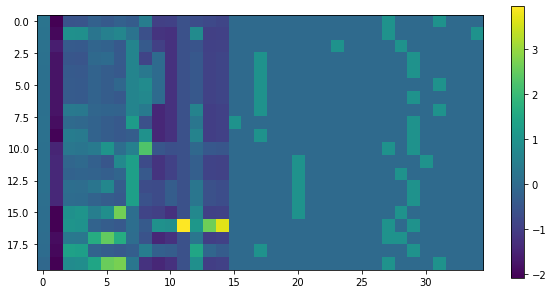

In [28]:
features = list(X_df.drop(["landcover_", "direction_"], axis=1).columns) + \
    list(lb_landcover.classes_) + list(lb_direction.classes_)
features_df = pd.DataFrame()
features_df["feature"] = features
display(features_df)

start = 50
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(X[start:start + 20])
plt.colorbar(im)
plt.show()

#### Visualize targets

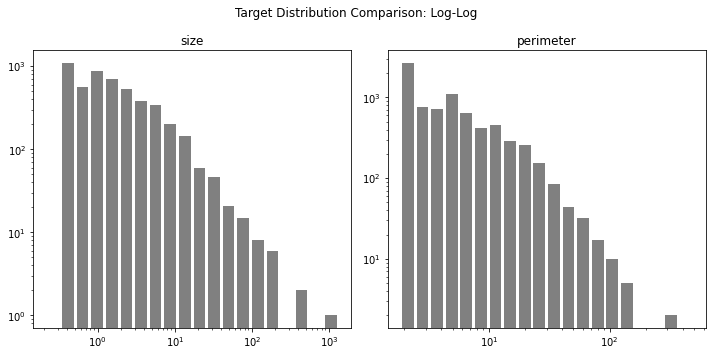

In [29]:
n_bins = 20
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i, target in enumerate(["size", "perimeter"]):
    hist, bins = np.histogram(y_df[target], bins=n_bins)
    logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))
    ax[i].hist(y_df[target], log=True, bins=logbins, rwidth=0.8, color="grey")
    ax[i].set_xscale("log")
    ax[i].set_title(target)

fig.suptitle("Target Distribution Comparison: Log-Log")
plt.tight_layout()
plt.show()

#### Choose 1 target to work with

In [30]:
y = np.log(y_df["size"] + 1)

#### Partition train/test sets

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=847, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5370, 35), (5370,), (2302, 35), (2302,))

## 2. Model

#### Test Standard ML Models

In [32]:
models = {
    "LinearRegression": LinearRegression(),
    "RidgeCV": RidgeCV(),
    "LassoCV": LassoCV(max_iter=1e4, random_state=847),
    "ElasticNetCV": ElasticNetCV(max_iter=1e4, random_state=847),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=847),
    "SVR - RBF": SVR(kernel="rbf"),
    "SVR - Linear": SVR(kernel="linear"),
    "KernelRidge - RBF": KernelRidge(kernel="rbf"),
    "KernelRidge - Linear": KernelRidge(kernel="linear"),
    "BaggingRegressor": BaggingRegressor(random_state=847),
    "RandomForestRegressor": RandomForestRegressor(random_state=847),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=847),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=847),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=847),
}
performance = []

for name, model in models.items():

    # fit + predict
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)

    # evaluate
    rmse = mean_squared_error(y_test, y_hat, squared=False)
    mae = mean_absolute_error(y_test, y_hat)
    rho = pearsonr(y_test, y_hat)[0]

    # report
    print(f"[{name}]")
    print(f"\tMAE      = {mae}")
    print(f"\tRMSE     = {rmse}")
    print(f"\tPearsonR = {rho}")

    # log performance
    performance.append({"model": name, "MAE": mae, "RMSE": rmse, "PearsonR": rho})

[LinearRegression]
	MAE      = 0.13021401551036962
	RMSE     = 0.2257974986981657
	PearsonR = 0.9529249253723465
[RidgeCV]
	MAE      = 0.13035794710350299
	RMSE     = 0.22608595347667493
	PearsonR = 0.9527810299260251
[LassoCV]
	MAE      = 0.13110933589780024
	RMSE     = 0.22819184804641796
	PearsonR = 0.9518207681691144
[ElasticNetCV]
	MAE      = 0.1478448518806432
	RMSE     = 0.2547932270519988
	PearsonR = 0.9395721025074196
[DecisionTreeRegressor]
	MAE      = 0.1533383026858471
	RMSE     = 0.3244845086400222
	PearsonR = 0.9035066111955198
[SVR - RBF]
	MAE      = 0.15241114859102947
	RMSE     = 0.284999101945357
	PearsonR = 0.9249424958751268
[SVR - Linear]
	MAE      = 0.1428551414972711
	RMSE     = 0.24858333240562444
	PearsonR = 0.9477210877827822
[KernelRidge - RBF]
	MAE      = 0.15567010511264281
	RMSE     = 0.3056278719424025
	PearsonR = 0.9131197813496584
[KernelRidge - Linear]
	MAE      = 0.13359678024589722
	RMSE     = 0.23185961566093088
	PearsonR = 0.950230488437913
[Baggin

In [33]:
performance_df = pd.DataFrame(performance)
performance_df

,model,MAE,RMSE,PearsonR
0,LinearRegression,0.130214,0.225797,0.952925
1,RidgeCV,0.130358,0.226086,0.952781
2,LassoCV,0.131109,0.228192,0.951821
3,ElasticNetCV,0.147845,0.254793,0.939572
4,DecisionTreeRegressor,0.153338,0.324485,0.903507
5,SVR - RBF,0.152411,0.284999,0.924942
6,SVR - Linear,0.142855,0.248583,0.947721
7,KernelRidge - RBF,0.155670,0.305628,0.913120
8,KernelRidge - Linear,0.133597,0.231860,0.950230
9,BaggingRegressor,0.116950,0.236579,0.948070


In [34]:
features_df["W_Linear"] = models["LinearRegression"].coef_
features_df["W_Lasso"] = models["LassoCV"].coef_
features_df["W_Ridge"] = models["RidgeCV"].coef_
features_df["W_Elastic"] = models["ElasticNetCV"].coef_
features_df["W_Tree"] = models["DecisionTreeRegressor"].feature_importances_

with pd.option_context('display.float_format', '{:.6f}'.format):
    display(features_df)

,feature,W_Linear,W_Lasso,W_Ridge,W_Elastic,W_Tree
0,latitude_x,-0.006339,-0.010699,-0.006864,-0.018128,0.010377
1,longitude_,0.003380,0.000000,0.003710,0.003938,0.010169
2,start_DOY,-5.700895,-4.963756,-5.553796,-2.734639,0.008737
3,end_DOY,5.703291,4.967341,5.562188,2.824186,0.012667
4,expansion,-0.408164,-0.408568,-0.408815,-0.417102,0.079063
5,fire_line,0.581234,0.570188,0.579653,0.544563,0.016200
6,speed,0.285962,0.303231,0.289207,0.352468,0.772629
7,elevation,-0.010987,-0.001893,-0.010465,0.000000,0.010341
8,distance_f,0.003043,0.003327,0.003226,0.005576,0.006792
9,DP01,-0.007686,-0.005785,-0.007507,-0.001177,0.004120


#### Test Deep MLP Models

In [35]:
deep_models = {
    "MLP - 100x1": MLPRegressor(random_state=847),
    "MLP - 100x2": MLPRegressor(hidden_layer_sizes=[100]*2, random_state=847),
    "MLP - 100x5": MLPRegressor(hidden_layer_sizes=[100]*5, random_state=847),
    "MLP - 100x10": MLPRegressor(hidden_layer_sizes=[100]*10, random_state=847),
    "MLP - 1x10": MLPRegressor(hidden_layer_sizes=[1]*10, random_state=847),
    "MLP - 2x10": MLPRegressor(hidden_layer_sizes=[2]*10, random_state=847),
    "MLP - 5x10": MLPRegressor(hidden_layer_sizes=[5]*10, random_state=847),
    "MLP - 10x10": MLPRegressor(hidden_layer_sizes=[10]*10, random_state=847),
}
deep_performance = []

for name, model in deep_models.items():

    # fit + predict
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)

    # evaluate
    rmse = mean_squared_error(y_test, y_hat, squared=False)
    mae = mean_absolute_error(y_test, y_hat)
    rho = pearsonr(y_test, y_hat)[0]

    # report
    print(f"[{name}]")
    print(f"\tMAE      = {mae}")
    print(f"\tRMSE     = {rmse}")
    print(f"\tPearsonR = {rho}")

    # log performance
    deep_performance.append({"model": name, "MAE": mae, "RMSE": rmse, "PearsonR": rho})

[MLP - 100x1]
	MAE      = 0.10736422687415022
	RMSE     = 0.20498824016786812
	PearsonR = 0.9614520384687831
[MLP - 100x2]
	MAE      = 0.11279631966671701
	RMSE     = 0.23736273697047391
	PearsonR = 0.9491538583634568
[MLP - 100x5]
	MAE      = 0.1260616077659602
	RMSE     = 0.30830156748257215
	PearsonR = 0.9154362114083319
[MLP - 100x10]
	MAE      = 0.10937650003169637
	RMSE     = 0.22894180121277208
	PearsonR = 0.9517634140781447
[MLP - 1x10]
	MAE      = 0.5571628984942417
	RMSE     = 0.7444545065299557
	PearsonR = nan
[MLP - 2x10]
	MAE      = 0.5525255161949976
	RMSE     = 0.7440713373855232
	PearsonR = -0.027531069631760847
[MLP - 5x10]
	MAE      = 0.07145343938706744
	RMSE     = 0.12466800044011897
	PearsonR = 0.9861424833659096
[MLP - 10x10]
	MAE      = 0.08331376192388984
	RMSE     = 0.23121841190001577
	PearsonR = 0.9518267627354361


c:\users\andre\appdata\local\programs\python\python39\lib\site-packages\scipy\stats\stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


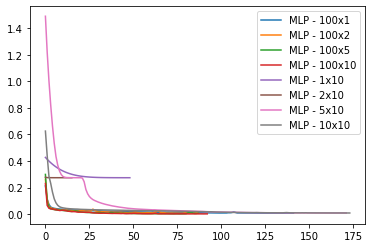

In [37]:
for name in deep_models.keys():
    plt.plot(deep_models[name].loss_curve_, label=name)
plt.legend()
plt.show()